# Exploring the Stackoverflow database

The required data is in the tables of the `stackoverflow` schema. The objctive of the project is to connect to the database using SQLAlchemy and write 10 SQL queries that will allow to calculate certain metrics for the database.

Project structure:
1. Importing libraries and connecting to the database
2. Execution of queries 
3. Visualisation of Retention Rate and number of posts by month

In [1]:
# importing libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine, text 

# Database connection configuration

In [2]:
# configuring the database connection

db_config = {
    'user': ' ... ', # username
    'pwd': ' ... ', # password
    'host': ' ... ',
    'port': 6432, # connection port
    'db': 'data-analyst-advanced-sql' # database name
}  

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

In [3]:
# connection to the database

engine = create_engine(connection_string)
conn = engine.connect()

# Task 1

Output the total sum of post views for each month of 2008. If there is no data for any month in the database, this month can be skipped. Sort the result in descending order of the total number of views.

In [4]:
# sql query
query = text('''
SELECT
    DATE_TRUNC('MONTH', creation_date) AS month_date,
    SUM(views_count) AS total_views
FROM stackoverflow.posts
WHERE EXTRACT(YEAR FROM creation_date) = 2008
GROUP BY month_date
ORDER BY total_views DESC
''')

# query output
df1 = pd.read_sql_query(query, conn) 
df1

,month_date,total_views
0,2008-09-01,452928568
1,2008-10-01,365400138
2,2008-11-01,221759651
3,2008-12-01,197792841
4,2008-08-01,131367083
5,2008-07-01,669895


The data is different across the presented months. In the summer months, as well as in December, there are significantly fewer requests. Considering that Stackoverflow is a platform for discussing issues related to development and other IT topics, it seems logical to assume that the number of requests drops during the holiday season and December. 

# Task 2

Display the names of the most active users who gave more than 100 answers in the first month after registration (including the day of registration). Do not take into account the questions asked by users. For each user name display the number of unique `user_id` values. Sort the result by the field with names in lexicographic order.

In [5]:
# sql query
query = text('''
SELECT
    u.display_name AS display_name,
    COUNT(DISTINCT(u.id))
FROM
    stackoverflow.users u JOIN stackoverflow.posts p ON u.id = p.user_id
    JOIN stackoverflow.post_types pt ON p.post_type_id = pt.id
WHERE p.creation_date < u.creation_date + INTERVAL '1 month' AND pt.type = 'Answer'
GROUP BY display_name
HAVING(COUNT(p.user_id) > 100)
ORDER BY display_name
''')

# query output
df2 = pd.read_sql_query(query, conn) 
df2

,display_name,count
0,1800 INFORMATION,1
1,Adam Bellaire,1
2,Adam Davis,1
3,Adam Liss,1
4,Alan,8
...,...,...
71,leppie,1
72,lomaxx,1
73,mattlant,1
74,paxdiablo,1


In [6]:
# Checking that values in the 'count' column
df2.sort_values(by='count', ascending=False) 

,display_name,count
43,Matt,29
10,Chris,29
14,Dan,21
62,Tom,19
40,Mark,16
...,...,...
37,Konrad Rudolph,1
1,Adam Bellaire,1
39,Marc Gravell,1
41,Mark Cidade,1


There can be more than one unique user id for one username. It seems that usually when registering, services insist on a unique username so that there is no confusion, but in this database there are, for example, 29 different usernames with the same name. That's suspicious.

# Task 3

Display the number of posts for 2008 by month. Select posts from users who registered in September 2008 and made at least one post in December of the same year. Sort the table by descending month value.

In [7]:
# sql query
query = text('''
SELECT DATE_TRUNC('month', p.creation_date)::date AS month,
       COUNT(p.id) 
FROM stackoverflow.posts AS p
WHERE user_id IN
                (SELECT u.id
                 FROM stackoverflow.posts AS p
                 JOIN stackoverflow.users AS u ON p.user_id = u.id 
                 WHERE p.creation_date::date BETWEEN '2008-12-01' AND '2008-12-31'
                       AND u.creation_date::date BETWEEN '2008-09-01' AND '2008-09-30'  
                 GROUP BY u.id
                 HAVING COUNT(p.id)>0
                 )
GROUP BY DATE_TRUNC('month', p.creation_date)::date
ORDER BY DATE_TRUNC('month', p.creation_date)::date DESC;
''')

# query output
df3 = pd.read_sql_query(query, conn) 
df3

,month,count
0,2008-12-01,17641
1,2008-11-01,18294
2,2008-10-01,27171
3,2008-09-01,24870
4,2008-08-01,32


The smallest number of posts is in December. Probably the reason is the same as was mentioned for the first task - people post less in the month with Christmas and New Year's Eve.

# Task 4

Using the post data, output several fields:

- ID of the user who wrote the post;
- the date the post was created;
- the number of views of the current post;
- the sum of views of the author's posts with accumulation.

The data in the table should be sorted by ascending order of user IDs, and data about the same user - by ascending order of post creation date.

In [8]:
# sql query
query = text('''
SELECT
    user_id,
    creation_date,
    views_count,
    SUM(views_count) OVER(PARTITION BY user_id ORDER BY creation_date) AS cumulative_count
FROM stackoverflow.posts
GROUP BY user_id, creation_date, views_count
ORDER BY user_id
''')

# query output
df4 = pd.read_sql_query(query, conn) 
df4

,user_id,creation_date,views_count,cumulative_count
0,1,2008-07-31 23:41:00,480476,480476
1,1,2008-07-31 23:55:38,136033,616509
2,1,2008-07-31 23:56:41,0,616509
3,1,2008-08-04 02:45:08,0,616509
4,1,2008-08-04 04:31:03,0,616509
...,...,...,...,...
243791,5696608,2008-12-23 16:00:37,0,2804
243792,5696608,2008-12-23 17:35:09,0,2804
243793,5696608,2008-12-24 01:02:48,0,2804
243794,5696608,2008-12-30 14:34:45,0,2804


# Task 5

Find the average number of user posts per day for August 2008. Select data on users who published more than 120 posts in August. Do not count the days with no posts. 

Sort the results in ascending order of the average number of posts. You don't need to round the values.

In [9]:
# sql query
query = text('''
WITH temp2 AS (
    SELECT
        COUNT(id) as post_count,
        user_id
    FROM stackoverflow.posts
    WHERE creation_date::date BETWEEN '2008-08-01' AND '2008-08-31' AND user_id IN (SELECT user_id
                        FROM stackoverflow.posts
                        WHERE creation_date::date BETWEEN '2008-08-01' AND '2008-08-31'
                        GROUP BY user_id
                        HAVING(COUNT(id) > 120)) 
                        GROUP BY user_id, creation_date::date
)
SELECT user_id,
    AVG(post_count) AS avg_daily
FROM temp2
GROUP BY user_id
ORDER BY avg_daily
''')

# query output
df5 = pd.read_sql_query(query, conn) 
df5

,user_id,avg_daily
0,116,4.777778
1,234,5.208333
2,91,5.681818
3,905,7.000000
4,383,7.277778


# Task 6

On average, how many days between December, 1 and December, 7 2008 did users interact with the platform? For each user, select the days on which he or she published at least one post. You need to get a single integer - don't forget to round the result. 

In [10]:
# sql query
query = text('''
with temp1 AS (SELECT
    user_id,
    COUNT(DISTINCT(DATE_TRUNC('day', creation_date))) AS day_count
FROM stackoverflow.posts
WHERE (DATE_TRUNC('day', creation_date)) BETWEEN '2008-12-01' AND '2008-12-07'
GROUP BY user_id
HAVING(COUNT(id) >= 1))
SELECT ROUND(AVG(day_count))::INT AS result
FROM temp1
''')

# query output
df6 = pd.read_sql_query(query, conn) 
df6

,result
0,2


Without additional breakdowns by days/users, we can note that on average users visited the platform about twice a week in the period under consideration. Probably due to the fact that it's a community for communicating on development and IT related issues rather than a general purpose social network, users are not interested in logging in just for fun, so they log in less frequently. And we should also take into account that we have data for 2008, when the platform was just launched, and users probably haven't had time to "get hooked" to it yet. 

# Task 7

Output the activity history of each user in the following form: user ID, post creation date. Sort the output in ascending order of user IDs, and for each user - in ascending order of publication date.

Add a new field to the table: for each post it will contain the name of the month of the penultimate publication of the user relative to the current one. If there is no such publication, specify `NULL`.  Python will automatically change `NULL` to `None`, but you don't need to convert `None` values additionally.

In [11]:
# sql query
query = text('''
SELECT user_id, creation_date, 
       LAG(to_char(creation_date, 'Month'), 2) OVER (PARTITION BY user_id ORDER BY creation_date) AS second_last_month
FROM stackoverflow.posts
ORDER BY user_id, creation_date;
''')

# query output
df7 = pd.read_sql_query(query, conn) 
df7

,user_id,creation_date,second_last_month
0,1,2008-07-31 23:41:00,None
1,1,2008-07-31 23:55:38,None
2,1,2008-07-31 23:56:41,July
3,1,2008-08-04 02:45:08,July
4,1,2008-08-04 04:31:03,July
...,...,...,...
243791,5696608,2008-12-23 16:00:37,December
243792,5696608,2008-12-23 17:35:09,December
243793,5696608,2008-12-24 01:02:48,December
243794,5696608,2008-12-30 14:34:45,December


# Task 8

Calculate the monthly Retention Rate analog for StackOverflow users. Group the users into cohorts based on the month of their first post. Define retention by the presence of a post in the current month.

| cohort_dt | session_date | users_cnt | cohort_users_cnt | retention_rate |
| --- | --- | --- | --- | --- |
| 2008-07-01 00:00:00 | 2008-07-01 00:00:00 | 3 | 3 | 100 |
| 2008-07-01 00:00:00 | 2008-08-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-07-01 00:00:00 | 2008-09-01 00:00:00 | 1 | 3 | 33,33 |
| 2008-07-01 00:00:00 | 2008-10-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-07-01 00:00:00 | 2008-11-01 00:00:00 | 1 | 3 | 33,33 |
| 2008-07-01 00:00:00 | 2008-12-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-08-01 00:00:00 | 2008-08-01 00:00:00 | 2151 | 2151 | 100 |
| ... | ... | ... | ... | ... |

In [12]:
# sql query
query = text('''
WITH profile AS (
    SELECT 
        u.id,
        MIN(DATE_TRUNC('month', (p.creation_date)))::date AS cohort_dt,
        COUNT(u.id) OVER(PARTITION BY DATE_TRUNC('month', min(p.creation_date))::date) AS cohort_users_cnt
    FROM stackoverflow.users u join stackoverflow.posts p on u.id = p.user_id
    GROUP BY u.id
),
sessions AS (
    SELECT 
        p.user_id,
        DATE_TRUNC('month', p.creation_date)::date AS session_date
    FROM stackoverflow.posts p
    GROUP BY p.user_id, session_date
)
SELECT
    cohort_dt,
    session_date,
    COUNT(p.id) AS users_cnt,
    cohort_users_cnt,
    ROUND(COUNT(p.id) * 100.0 / cohort_users_cnt, 2) AS retention_rate
FROM profile p JOIN sessions s ON p.id = s.user_id
    GROUP BY p.cohort_dt, s.session_date, p.cohort_users_cnt
''')

# query output
df8 = pd.read_sql_query(query, conn) 
df8

,cohort_dt,session_date,users_cnt,cohort_users_cnt,retention_rate
0,2008-08-01,2008-09-01,1571,2151,73.04
1,2008-07-01,2008-07-01,3,3,100.00
2,2008-11-01,2008-11-01,2852,2852,100.00
3,2008-08-01,2008-12-01,894,2151,41.56
4,2008-09-01,2008-12-01,2500,7678,32.56
5,2008-07-01,2008-12-01,2,3,66.67
6,2008-07-01,2008-11-01,1,3,33.33
7,2008-09-01,2008-10-01,4132,7678,53.82
8,2008-09-01,2008-09-01,7678,7678,100.00
9,2008-07-01,2008-08-01,2,3,66.67


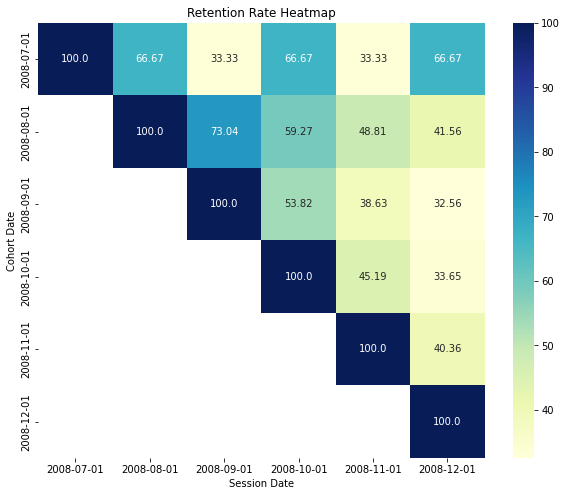

In [13]:
# Retention Rate heatmap
retention_matrix = df8.pivot(index='cohort_dt', columns='session_date', values='retention_rate')  
plt.figure(figsize=(10, 8))  
sns.heatmap(retention_matrix, annot=True, cmap='YlGnBu', fmt='')
plt.title('Retention Rate Heatmap')
plt.xlabel('Session Date')
plt.ylabel('Cohort Date')
plt.show()

On the heatmap, the July cohort stands out because it behaves strangely – retention fluctuates between two values. However, according to the table, the size of this cohort is three people, which explains this behavior. In the other cohorts presented, retention predictably decreases gradually.

# Task 9

By how much percent did the number of posts change each month from 1 September to 31 December 2008? Display a table with the following fields:

- month number;
- the number of posts for the month;
- a percentage that shows how much the number of posts in the current month has changed from the previous month.

If there are fewer posts, the percentage should be negative; if there are more posts, the percentage should be positive. Round the percentage value to two decimals.

In [14]:
# sql query
query = text('''
SELECT
    (EXTRACT(MONTH FROM creation_date))::int AS creation_month,
    COUNT(*) AS posts_count,
    ROUND((COUNT(*) - LAG(COUNT(*)) OVER (ORDER BY EXTRACT(MONTH FROM creation_date)))::numeric / LAG(COUNT(*)) OVER (ORDER BY EXTRACT(MONTH FROM creation_date)) * 100, 2) AS percentage
FROM
    stackoverflow.posts
WHERE
    creation_date >= '2008-09-01' AND creation_date <= '2008-12-31'
GROUP BY
    EXTRACT(MONTH FROM creation_date)
ORDER BY
    EXTRACT(MONTH FROM creation_date);
''')

# query output
df9 = pd.read_sql_query(query, conn) 
df9

,creation_month,posts_count,percentage
0,9,70371,NaN
1,10,63102,-10.33
2,11,46975,-25.56
3,12,44592,-5.07


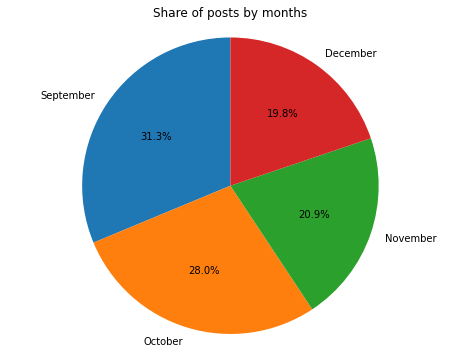

In [15]:
# Pie chart with month shares
months = ['September', 'October', 'November', 'December']
post_counts = df9['posts_count']

plt.figure(figsize=(8, 6))  
plt.pie(post_counts, labels=months, autopct='%1.1f%%', startangle=90)

plt.title('Share of posts by months') 
plt.axis('equal')
plt.show()

# Task 10

Display the activity data of the user who has published the most posts over time. Output the data for October 2008 in this form:

- week number;
- date and time of the last post published this week.

In [16]:
# sql query
query = text('''
SELECT
    EXTRACT(WEEK FROM DATE_TRUNC('week', creation_date))::int AS week_creation,
    MAX(creation_date) AS creation_date
FROM
    stackoverflow.posts
WHERE
    EXTRACT(YEAR FROM creation_date) = 2008
    AND EXTRACT(MONTH FROM creation_date) = 10
    AND user_id = (
        SELECT
            user_id
        FROM
            stackoverflow.posts
        GROUP BY
            user_id
        ORDER BY
            COUNT(*) DESC
        LIMIT 1
    )
GROUP BY
    week_creation
ORDER BY
    week_creation;
''')

# query output
df10 = pd.read_sql_query(query, conn) 
df10

,week_creation,creation_date
0,40,2008-10-05 09:00:58
1,41,2008-10-12 21:22:23
2,42,2008-10-19 06:49:30
3,43,2008-10-26 21:44:36
4,44,2008-10-31 22:16:01
